# **Fraud Detection Model Training and Evaluation**

The notebook focuses on training and evaluating multiple machine learning models for detecting fraudulent transactions using a credit card dataset. Below is a detailed breakdown of the process:

---

## **1. Data Preprocessing**

- **Data Loading and Normalization:**
  - Load the `creditcard.csv` dataset.
  - Normalize the `Amount` column using `StandardScaler` and drop the original `Amount` and `Time` columns.
  
- **Feature and Target Separation:**
  - Separate the dataset into features (`X`) and target labels (`y`), where `Class` represents whether a transaction is fraudulent.

- **Train-Test Split:**
  - Split the data into training and testing sets with a 70-30 split.

---

## **2. Decision Tree Model with Bayesian Optimization**

- **Model Initialization:**
  - A `DecisionTreeClassifier` is initialized with a search space for hyperparameters.

- **Bayesian Optimization:**
  - Use `BayesSearchCV` to optimize hyperparameters (`max_depth`, `min_samples_split`, etc.) over 30 iterations.
  
- **Evaluation:**
  - The best model is evaluated using a confusion matrix, accuracy, precision, recall, and F1 score.

---

## **3. Random Forest Model with Bayesian Optimization**

- **Model Initialization and Optimization:**
  - Similar Bayesian optimization process is applied to `RandomForestClassifier` with a reduced search space and iterations.
  
- **Evaluation:**
  - The best model is evaluated using metrics and confusion matrices for both test and entire datasets.

---

## **4. Handling Imbalanced Data**

- **Undersampling:**
  - Reduce the majority class samples to balance the dataset.
  - Train and evaluate a Random Forest model using the undersampled dataset.

- **Oversampling using SMOTE:**
  - Use SMOTE to generate synthetic samples for the minority class.
  - Train and evaluate the model with the oversampled dataset.

---

## **5. Feedforward Neural Network Model**

- **Model Definition:**
  - Define a simple feedforward neural network using Keras, consisting of multiple dense layers with dropout for regularization.

- **Training and Evaluation:**
  - Train the model on different datasets (original, undersampled, oversampled).
  - Evaluate the model using confusion matrix and common metrics (accuracy, precision, recall, F1 score).

---

## **6. Autoencoder Model for Anomaly Detection**

- **Autoencoder Definition and Optimization:**
  - Define an autoencoder to detect anomalies based on reconstruction error.
  - Use Bayesian optimization to tune the number of neurons in the encoder and decoder layers.

- **Training and Evaluation:**
  - Train the autoencoder with early stopping and validate using reconstruction error.
  - Classify transactions based on the reconstruction error threshold.

- **Handling Different Sampling Strategies:**
  - Separate optimization and evaluation for undersampled and oversampled datasets.

---

## **Key Insights:**

- **Balanced Data Handling:**
  - Different sampling strategies (undersampling, oversampling with SMOTE) significantly affect model performance, especially for imbalanced datasets like fraud detection.

- **Model Optimization:**
  - Bayesian optimization is used extensively for hyperparameter tuning, enhancing the model's performance on test data.

- **Neural Network Application:**
  - The use of feedforward and autoencoder models showcases deep learning techniques for fraud detection, emphasizing the importance of reconstruction error in anomaly detection.

- **Evaluation Metrics:**
  - Consistent evaluation using confusion matrices and various metrics (accuracy, precision, recall, F1 score) provides a comprehensive understanding of model effectiveness.



## **1. Data Preprocessing**

In [150]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization

np.random.seed(2)
smote = SMOTE(random_state=42)

## **2. Decision Tree Model with Bayesian Optimization**

In [151]:
data = pd.read_csv('creditcard.csv')

data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [152]:
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Amount'],axis=1)
data = data.drop(['Time'],axis=1)

data.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normalizedAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [153]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

print(y.head())
print(X.head())

   Class
0      0
1      0
2      0
3      0
4      0
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.098698  0.363787  0.090794  ...  0.251412 -0.018307  0.277838 -0.110474   
1  0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775 -0.638672  0.101288   
2  0.247676 -1.514654  0.207643  ...  0.524980  0.247998  0.771679  0.909412   
3  0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300  0.005274 -0.190321   
4 -0.270533  0.817739  0.753074  ...  0.408542 -0.009431  0.798278 -0.137458   

        V24   

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(199364, 29)
(85443, 29)
(199364, 1)
(85443, 1)


In [155]:
# Define a simpler search space for hyperparameters
search_space = {
    'max_depth': Integer(2, 16),  
    'min_samples_split': Integer(2, 50),  
    'min_samples_leaf': Integer(1, 50),  
    'criterion': Categorical(['gini', 'entropy']),  # Criterion for splitting
}


## **2. Decision Tree Model with Bayesian Optimization**

In [156]:
# Initialize the model
decision_tree = DecisionTreeClassifier()


In [157]:
# Set up Bayesian optimization
bayes_search = BayesSearchCV(
    decision_tree,
    search_space,
    n_iter=30,  # Number of iterations
    n_jobs=-1,
    cv=5 # 5-fold cross-validation
)

In [158]:
# Fit the model with the optimizer
bayes_search.fit(X_train, y_train.values.ravel())

# Get the best model
best_model = bayes_search.best_estimator_

In [159]:
# Predictions
y_pred_decision_tress = best_model.predict(X_test)

# Scoring
score = best_model.score(X_test, y_test)

print(f'Best Parameters: {bayes_search.best_params_}')
print(f'Test Score: {score}')

Best Parameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 16), ('min_samples_leaf', 12), ('min_samples_split', 2)])
Test Score: 0.9993914071369217


In [301]:
def plot_confusion_matrix(cm, classes,
                          normalize=True, # True for normalization and False for normalization
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Define the threshold for changing the text color in the blocks
    thresh = cm.max() / 2.

    # Annotate the blocks
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}\n(TP)" if i == j and i == 1 else
                 f"{cm[i, j]:.2f}\n(TN)" if i == j and i == 0 else
                 f"{cm[i, j]:.2f}\n(FP)" if j == 1 else
                 f"{cm[i, j]:.2f}\n(FN)",
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion Matrix 
[[85281    15]
 [   37   110]]
Normalized confusion matrix
[[9.99824142e-01 1.75858188e-04]
 [2.51700680e-01 7.48299320e-01]]


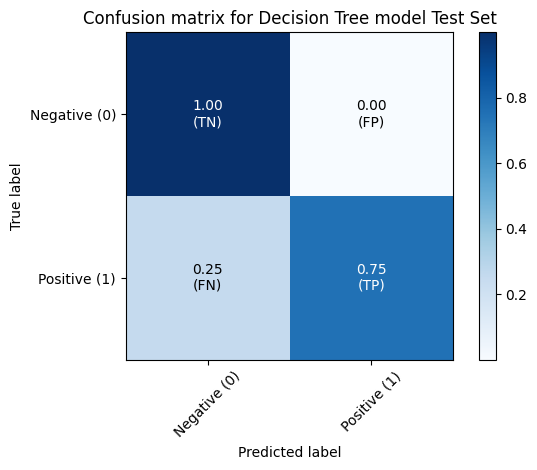

In [218]:
y_expected_decision_tress = pd.DataFrame(y_test)

# Calculate the confusion matrix for the Decision Tree model test dataset
cnf_matrix = confusion_matrix(y_expected_decision_tress, y_pred_decision_tress.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Decision Tree model Test Set')
plt.show()

In [162]:
# Calculate metrics for test set
accuracy = accuracy_score(y_expected_decision_tress, y_pred_decision_tress)
precision = precision_score(y_expected_decision_tress, y_pred_decision_tress)
recall = recall_score(y_expected_decision_tress, y_pred_decision_tress)
f1 = f1_score(y_expected_decision_tress, y_pred_decision_tress)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9994
Precision: 0.8800
Recall: 0.7483
F1 Score: 0.8088


Confusion Matrix 
[[284283     32]
 [   105    387]]
Normalized confusion matrix
[[9.99887449e-01 1.12551220e-04]
 [2.13414634e-01 7.86585366e-01]]


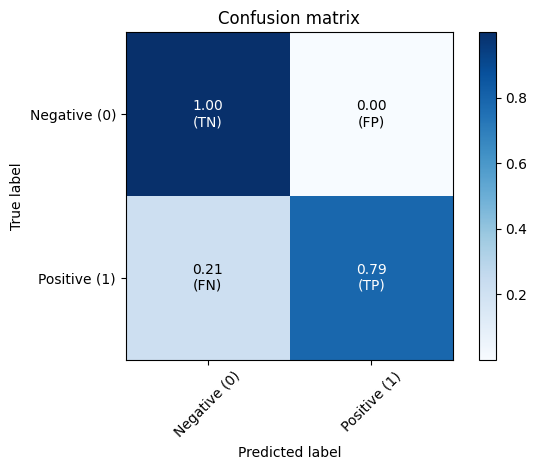

In [163]:
y_pred_decision_tress_all = best_model.predict(X)

y_expected_decision_tress_all = pd.DataFrame(y)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_expected_decision_tress_all, y_pred_decision_tress_all.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])
plt.show()

In [164]:
# Calculate metrics for entire set
accuracy = accuracy_score(y_expected_decision_tress_all, y_pred_decision_tress_all)
precision = precision_score(y_expected_decision_tress_all, y_pred_decision_tress_all)
recall = recall_score(y_expected_decision_tress_all, y_pred_decision_tress_all)
f1 = f1_score(y_expected_decision_tress_all, y_pred_decision_tress_all)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9995
Precision: 0.9236
Recall: 0.7866
F1 Score: 0.8496


## **3. Random Forest Model with Bayesian Optimization**

In [165]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(199364, 29)
(85443, 29)
(199364, 1)
(85443, 1)


In [166]:
# Adjusted parameter space for quicker evaluation
search_spaces = {
    'n_estimators': Integer(100, 150),  
    'max_depth': Integer(5, 15),  
    'min_samples_split': Integer(2, 5),  
    'min_samples_leaf': Integer(1, 3), 
    'bootstrap': Categorical([True]) 
}

In [167]:
# Initialize the RandomForestClassifier
random_forest = RandomForestClassifier(random_state=42)

# Set up the Bayesian optimizer with simplified search spaces and reduced CV folds
bayes_search = BayesSearchCV(
    estimator=random_forest, 
    search_spaces=search_spaces, 
    n_iter=2,  # Reduced number of iterations for speed
    cv=2,  # Reduced CV folds
    n_jobs=-1, 
    verbose=1, 
    random_state=42
)

# Fit the Bayesian optimizer to the training data
bayes_search.fit(X_train, y_train) 

# Print the best parameters and the corresponding score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score: ", bayes_search.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters found:  OrderedDict([('bootstrap', True), ('max_depth', 14), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 143)])
Best score:  0.9994883730262234


Confusion Matrix 
[[85289     7]
 [   37   110]]
Normalized confusion matrix
[[9.99917933e-01 8.20671544e-05]
 [2.51700680e-01 7.48299320e-01]]


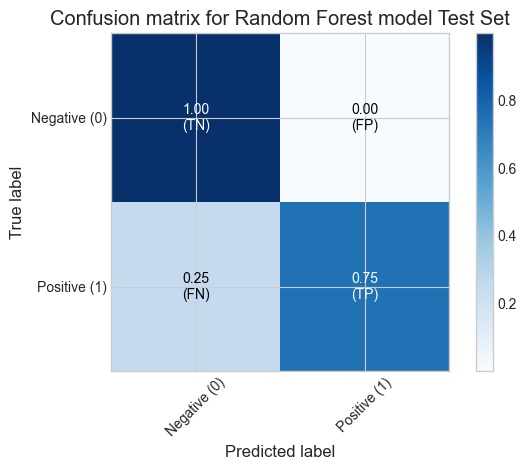

In [305]:
# Use the best model to make predictions for test set 
y_pred_random_forest = bayes_search.predict(X_test)
y_expected_random_forest = pd.DataFrame(y_test)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_expected_random_forest,y_pred_random_forest)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Random Forest model Test Set')
plt.show()

In [169]:
# Calculate metrics for test set 
accuracy = accuracy_score(y_expected_random_forest, y_pred_random_forest)
precision = precision_score(y_expected_random_forest, y_pred_random_forest)
recall = recall_score(y_expected_random_forest, y_pred_random_forest)
f1 = f1_score(y_expected_random_forest, y_pred_random_forest)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9995
Precision: 0.9402
Recall: 0.7483
F1 Score: 0.8333


Confusion Matrix 
[[284306      9]
 [    94    398]]
Normalized confusion matrix
[[9.99968345e-01 3.16550305e-05]
 [1.91056911e-01 8.08943089e-01]]


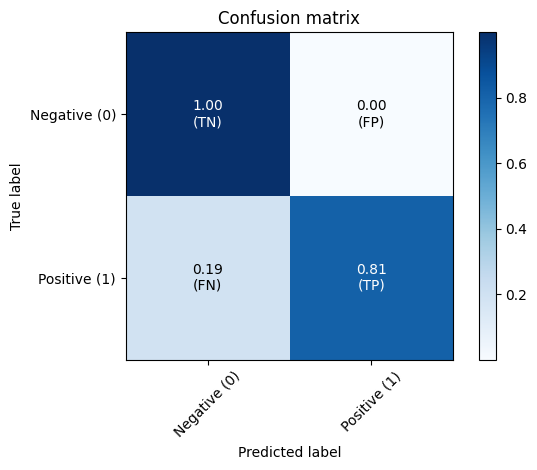

In [170]:
# Use the best model to make predictions for entire set 
y_pred_random_forest_all = bayes_search.predict(X)
y_expected_random_forest_all = pd.DataFrame(y)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_expected_random_forest_all, y_pred_random_forest_all.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])
plt.show()

In [171]:
# Calculate metrics for test set 
accuracy = accuracy_score(y_expected_random_forest_all, y_pred_random_forest_all)
precision = precision_score(y_expected_random_forest_all, y_pred_random_forest_all)
recall = recall_score(y_expected_random_forest_all, y_pred_random_forest_all)
f1 = f1_score(y_expected_random_forest_all, y_pred_random_forest_all)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9996
Precision: 0.9779
Recall: 0.8089
F1 Score: 0.8854


## **4. Handling Imbalanced Data**

In [172]:
# Find indices of each class's observations
fraud_indices = np.array(y_train[y_train == 1].index)
normal_indices = np.array(y_train[y_train == 0].index)

# Randomly sample normal indices to match the number of fraud indices
random_normal_indices = np.random.choice(normal_indices, len(fraud_indices), replace=False)

# Combine indices to form the undersampled dataset
undersample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Extract undersampled dataset
X_train_undersample = X_train.loc[undersample_indices]
y_train_undersample = y_train.loc[undersample_indices]

# convert to numpy arrays
X_train_undersample = np.array(X_train_undersample)
y_train_undersample = np.array(y_train_undersample)

In [173]:
# Initialize the RandomForestClassifier
random_forest_undersampled = RandomForestClassifier(random_state=42)

# Set up the Bayesian optimizer with simplified search spaces and reduced CV folds
bayes_search_undersampled = BayesSearchCV(
    estimator=random_forest_undersampled, 
    search_spaces=search_spaces, 
    n_iter=2,  # Reduced number of iterations for speed
    cv=2,  # Reduced CV folds
    n_jobs=-1, 
    verbose=1, 
    random_state=42
)

# Fit the Bayesian optimizer to the training data
bayes_search_undersampled.fit(X_train_undersample, y_train_undersample) 

# Print the best parameters and the corresponding score
print("Best parameters found: ", bayes_search_undersampled.best_params_)
print("Best score: ", bayes_search_undersampled.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters found:  OrderedDict([('bootstrap', True), ('max_depth', 14), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 143)])
Best score:  0.9997090748580486


/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix 
[[85289     7]
 [   35   112]]
Normalized confusion matrix
[[9.99917933e-01 8.20671544e-05]
 [2.38095238e-01 7.61904762e-01]]


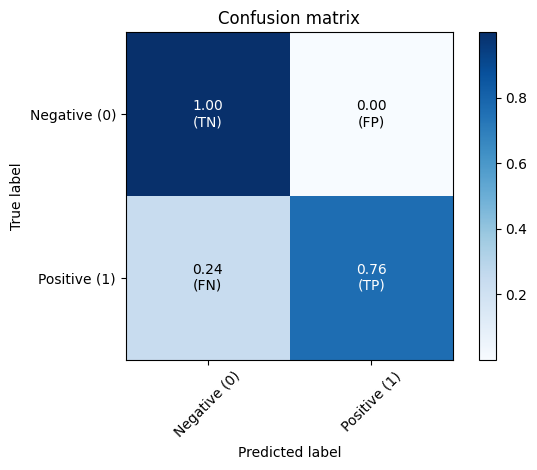

In [174]:
# prediction for test set
y_pred_random_forest_undersampled = bayes_search_undersampled.predict(X_test)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_random_forest_undersampled)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Random Forest model Test Set Undersampled')
plt.show()


In [175]:
# Calculate metrics for test set
accuracy = accuracy_score(y_test, y_pred_random_forest_undersampled)
precision = precision_score(y_test, y_pred_random_forest_undersampled)
recall = recall_score(y_test, y_pred_random_forest_undersampled)
f1 = f1_score(y_test, y_pred_random_forest_undersampled)

# print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9995
Precision: 0.9412
Recall: 0.7619
F1 Score: 0.8421


Confusion Matrix 
[[284306      9]
 [    94    398]]
Normalized confusion matrix
[[9.99968345e-01 3.16550305e-05]
 [1.91056911e-01 8.08943089e-01]]


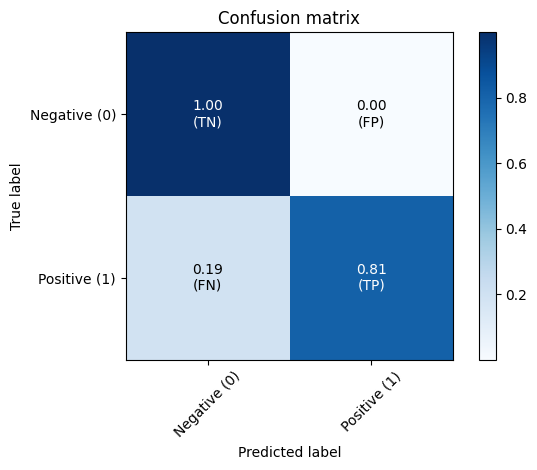

In [176]:
# prediction for entire set under sampled
y_pred_random_forest_undersampled_all = bayes_search.predict(X)
y_test_all = y

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test_all, y_pred_random_forest_undersampled_all)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])


In [177]:
# Calculate metrics for entire set under sampled
accuracy = accuracy_score(y_test_all, y_pred_random_forest_undersampled_all)
precision = precision_score(y_test_all, y_pred_random_forest_undersampled_all)
recall = recall_score(y_test_all, y_pred_random_forest_undersampled_all)
f1 = f1_score(y_test_all, y_pred_random_forest_undersampled_all)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.9996
Precision: 0.9779
Recall: 0.8089
F1 Score: 0.8854


SMOTE OVERSAMPLING

In [178]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train.values.ravel())

X_train_resampled = np.array(X_train)
y_train_resampled = np.array(y_train)


In [179]:
# Initialize the RandomForestClassifier
random_forest_oversampled = RandomForestClassifier(random_state=42)

# Set up the Bayesian optimizer with simplified search spaces and reduced CV folds
bayes_search_oversampled = BayesSearchCV(
    estimator=random_forest_oversampled, 
    search_spaces=search_spaces, 
    n_iter=2,  # Reduced number of iterations for speed
    cv=2,  # Reduced CV folds
    n_jobs=-1, 
    verbose=1, 
    random_state=42
)

# Fit the Bayesian optimizer to the training data
bayes_search_oversampled.fit(X_train_resampled, y_train_resampled) 

# Print the best parameters and the corresponding score
print("Best parameters found: ", bayes_search_oversampled.best_params_)
print("Best score: ", bayes_search_oversampled.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters found:  OrderedDict([('bootstrap', True), ('max_depth', 14), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 143)])
Best score:  0.9994883730262234


/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix 
[[85289     7]
 [   37   110]]
Normalized confusion matrix
[[9.99917933e-01 8.20671544e-05]
 [2.51700680e-01 7.48299320e-01]]


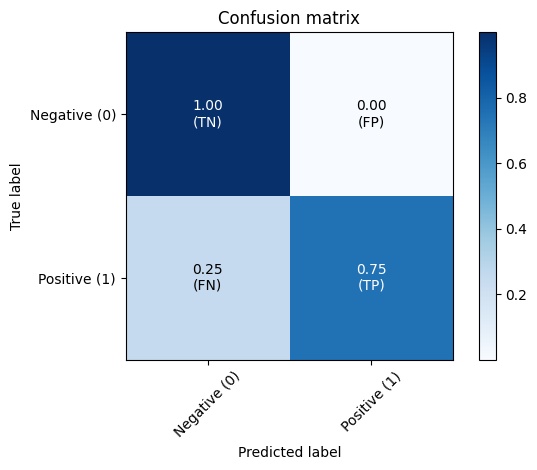

In [180]:
# prediction for test set
y_pred_random_forest_oversampled = bayes_search_oversampled.predict(X_test)
y_test = pd.DataFrame(y_test)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_random_forest_oversampled)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])
plt.show()

In [181]:
# Calculate metrics for test set
accuracy = accuracy_score(y_test, y_pred_random_forest_oversampled)
precision = precision_score(y_test, y_pred_random_forest_oversampled)
recall = recall_score(y_test, y_pred_random_forest_oversampled)
f1 = f1_score(y_test, y_pred_random_forest_oversampled)

# print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.9995
Precision: 0.9402
Recall: 0.7483
F1 Score: 0.8333


Confusion Matrix 
[[284306      9]
 [    94    398]]
Normalized confusion matrix
[[9.99968345e-01 3.16550305e-05]
 [1.91056911e-01 8.08943089e-01]]


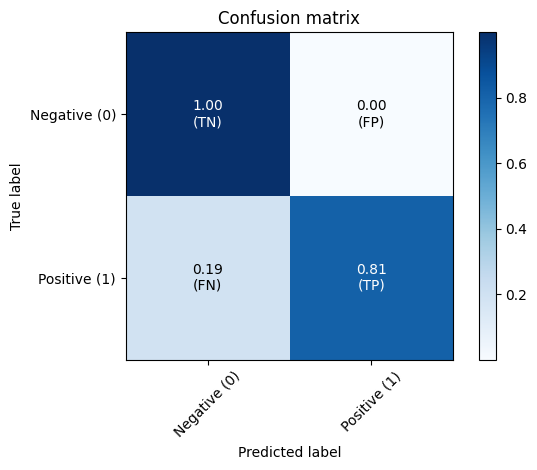

In [182]:
# prediction for entire set under sampled
y_pred_random_forest_oversampled_all = bayes_search.predict(X)
y_test_all = y

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test_all, y_pred_random_forest_oversampled_all)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])

In [351]:
def plot_roc_curve(y_tests, y_scores, labels):
    plt.figure(figsize=(12, 8))  # Increased figure size for a better aspect ratio
    lw = 2  # Line width for ROC curves

    # Set the style of the plot
    plt.style.use('_classic_test_patch')
    #plt.rc('font', family='sans-serif')
    
    # Plot the random model line with a new linestyle
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='grey', alpha=0.7, label="Random Model")

    # Define markers for each line for better differentiation
    markers = ['o', 's', '^', 'd', '*']  # Extended list of markers

    # Define line styles for each model for better differentiation
    line_styles = ['-', '--', '-.', ':']
    
    # Generate a high contrast color palette
    color_palette = ['blue', 'orange', 'green', 'red', 'brown']

    mark = [0.03, 0.07, 0.11, 0.15]

    # Generate a high contrast color palette
    #color_palette = plt.cm.tab10(np.linspace(0, 1, len(labels)))
    
    for (y_test, y_score, label), color, marker, ls, markevery in zip(zip(y_tests, y_scores, labels), color_palette, markers, line_styles, mark):
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, marker=marker,color=color, linestyle=ls, markevery=markevery, lw=lw, 
                  label=f'{label} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC Curve Comparison', fontsize=17)
    plt.legend(loc="lower right", fontsize=13, frameon=True, shadow=True, borderpad=1)
    plt.grid(True, linestyle='-', linewidth=1, color='grey', alpha=0.5)
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xlim([0 - 0.05, 1 + 0.05])
    plt.ylim([0 - 0.05, 1 + 0.05])

    # Removing the top and right spines for a cleaner look
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.show()


/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/francescostocchi/anaconda3/envs/advance_machine_learning/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


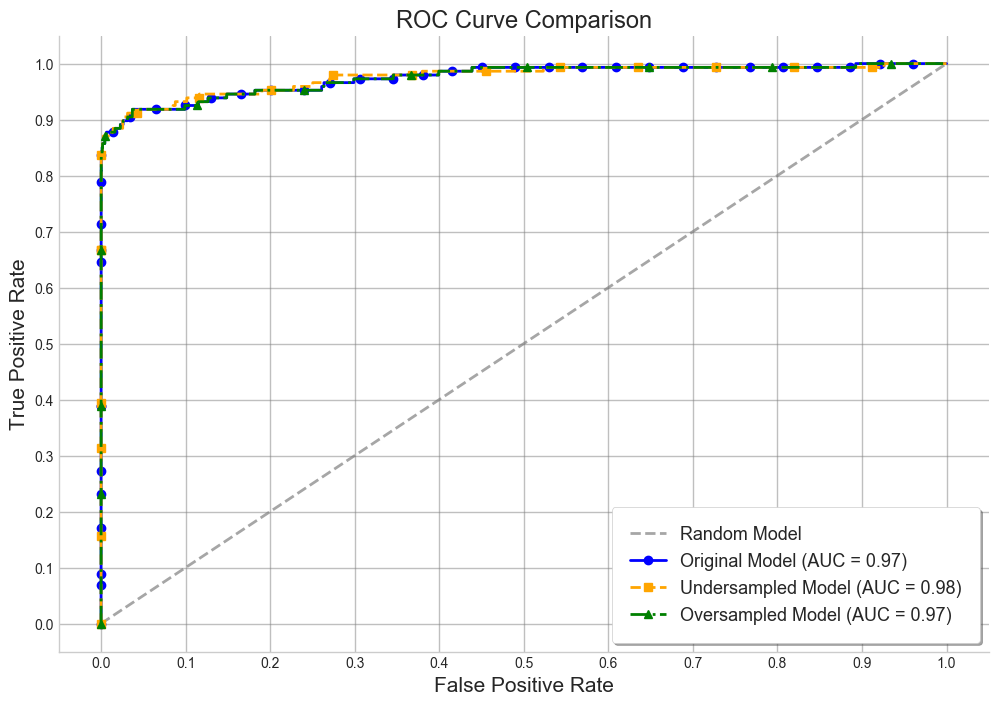

In [352]:
# Preparing data for plotting
y_tests = [y_test, y_test, y_test]  # Adjust based on your actual labels
y_scores = [
    bayes_search.predict_proba(X_test)[:, 1],  # Base model probabilities
    bayes_search_undersampled.predict_proba(X_test)[:, 1],  # Undersampled model probabilities
    bayes_search_oversampled.predict_proba(X_test)[:, 1]  # Oversampled model probabilities
]
labels = ['Original Model', 'Undersampled Model', 'Oversampled Model']

# Plot ROC curves
plot_roc_curve(y_tests, y_scores, labels)

## **5. Feedforward Neural Network Model**

In [185]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(199364, 29)
(85443, 29)
(199364, 1)
(85443, 1)


In [186]:
model = Sequential([
    Dense(units=16, input_dim = 29,activation='relu'),
    Dense(units=24,activation='relu'),
    Dropout(0.5),
    Dense(20,activation='relu'),
    Dense(24,activation='relu'),
    Dense(1,activation='sigmoid'),
])

In [187]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 16)                480       
                                                                 
 dense_39 (Dense)            (None, 24)                408       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_40 (Dense)            (None, 20)                500       
                                                                 
 dense_41 (Dense)            (None, 24)                504       
                                                                 
 dense_42 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1917 (7.49 KB)
Trainable params: 1917 (

In [221]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=29,epochs=5)

Epoch 1/5
6875/6875 [==============================] - 5s 709us/step - loss: 0.0024 - accuracy: 0.9995
Epoch 2/5
6875/6875 [==============================] - 5s 663us/step - loss: 0.0022 - accuracy: 0.9994
Epoch 3/5
6875/6875 [==============================] - 5s 764us/step - loss: 0.0022 - accuracy: 0.9995
Epoch 4/5
6875/6875 [==============================] - 5s 667us/step - loss: 0.0023 - accuracy: 0.9995
Epoch 5/5
6875/6875 [==============================] - 5s 704us/step - loss: 0.0020 - accuracy: 0.9995


In [222]:
score = model.evaluate(X_test, y_test)

print(score)

2671/2671 [==============================] - 1s 473us/step - loss: 0.0041 - accuracy: 0.9994
[0.004137143027037382, 0.9994499087333679]


2671/2671 [==============================] - 1s 355us/step
Confusion Matrix 
[[85286    10]
 [   37   110]]
Normalized confusion matrix
[[9.99882761e-01 1.17238792e-04]
 [2.51700680e-01 7.48299320e-01]]


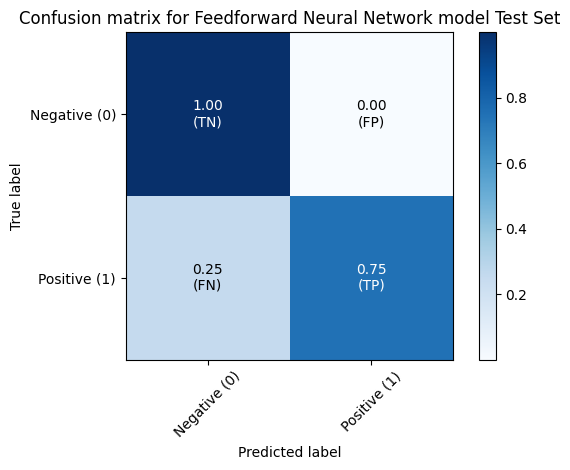

In [223]:
# Predictions
y_pred_feed = model.predict(X_test)
y_test_feed = pd.DataFrame(y_test)

# Calculate the confusion matrix and plot it for test set
cnf_matrix = confusion_matrix(y_test_feed, y_pred_feed.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Feedforward Neural Network model Test Set')  

In [191]:
# calculate metrics for test set
accuracy = accuracy_score(y_test_feed, y_pred_feed.round())
precision = precision_score(y_test_feed, y_pred_feed.round())
recall = recall_score(y_test_feed, y_pred_feed.round())
f1 = f1_score(y_test_feed, y_pred_feed.round())

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9994
Precision: 0.8613
Recall: 0.8027
F1 Score: 0.8310


8901/8901 [==============================] - 3s 378us/step
Confusion Matrix 
[[284287     28]
 [   119    373]]
Normalized confusion matrix
[[9.99901518e-01 9.84823171e-05]
 [2.41869919e-01 7.58130081e-01]]


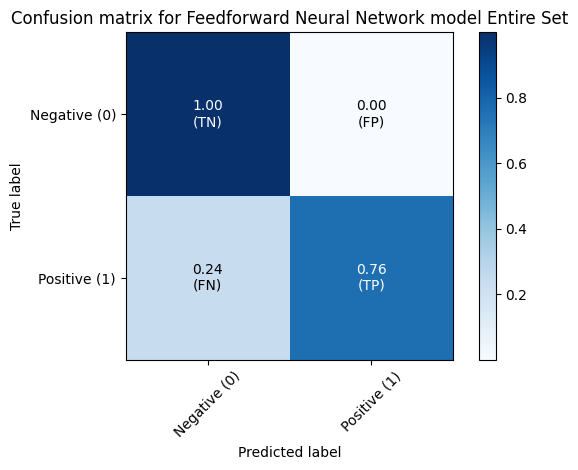

In [224]:
# predictions for entire set
y_pred_feed_all = model.predict(X)
y_test_feed_all = pd.DataFrame(y)

# Calculate the confusion matrix and plot it for entire set
cnf_matrix = confusion_matrix(y_test_feed_all, y_pred_feed_all.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Feedforward Neural Network model Entire Set')


Undersampling

In [225]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 16)                480       
                                                                 
 dense_39 (Dense)            (None, 24)                408       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_40 (Dense)            (None, 20)                500       
                                                                 
 dense_41 (Dense)            (None, 24)                504       
                                                                 
 dense_42 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1917 (7.49 KB)
Trainable params: 1917 (

In [226]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train_undersample,y_train_undersample,batch_size=30,epochs=5)

Epoch 1/5
13291/13291 [==============================] - 10s 704us/step - loss: 0.0022 - accuracy: 0.9994
Epoch 2/5
13291/13291 [==============================] - 10s 726us/step - loss: 0.0021 - accuracy: 0.9994
Epoch 3/5
13291/13291 [==============================] - 9s 662us/step - loss: 0.0020 - accuracy: 0.9994
Epoch 4/5
13291/13291 [==============================] - 9s 682us/step - loss: 0.0020 - accuracy: 0.9995
Epoch 5/5
13291/13291 [==============================] - 11s 803us/step - loss: 0.0021 - accuracy: 0.9995


2671/2671 [==============================] - 1s 359us/step
Confusion Matrix 
[[85282    14]
 [   40   107]]
Normalized confusion matrix
[[9.99835866e-01 1.64134309e-04]
 [2.72108844e-01 7.27891156e-01]]


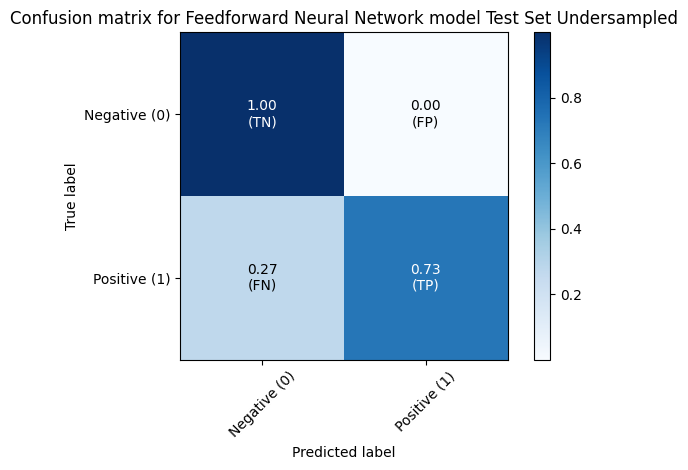

In [227]:
# make predictions
y_pred_feed_undersampled = model.predict(X_test)
y_test_feed_undersampled = pd.DataFrame(y_test)

# Calculate the confusion matrix and plot it for test set
cnf_matrix = confusion_matrix(y_test_feed_undersampled, y_pred_feed_undersampled.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Feedforward Neural Network model Test Set Undersampled')


In [228]:
# calculate metrics for test set under sampled
accuracy = accuracy_score(y_test_feed_undersampled, y_pred_feed_undersampled.round())
precision = precision_score(y_test_feed_undersampled, y_pred_feed_undersampled.round())
recall = recall_score(y_test_feed_undersampled, y_pred_feed_undersampled.round())
f1 = f1_score(y_test_feed_undersampled, y_pred_feed_undersampled.round())

# print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.9994
Precision: 0.8843
Recall: 0.7279
F1 Score: 0.7985


8901/8901 [==============================] - 3s 379us/step
Confusion Matrix 
[[284270     45]
 [   107    385]]
Normalized confusion matrix
[[9.99841725e-01 1.58275153e-04]
 [2.17479675e-01 7.82520325e-01]]


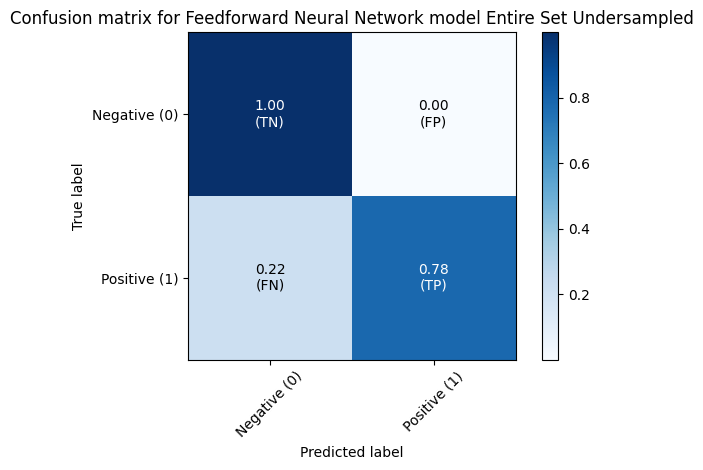

In [229]:
# make predictions for entire set
y_pred_feed_undersampled_all = model.predict(X)
y_test_feed_undersampled_all = pd.DataFrame(y)

# Calculate the confusion matrix and plot it for entire set
cnf_matrix = confusion_matrix(y_test_feed_undersampled_all, y_pred_feed_undersampled_all.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Feedforward Neural Network model Entire Set Undersampled')


In [230]:
# calculate metrics for entire set under sampled
accuracy = accuracy_score(y_test_feed_undersampled_all, y_pred_feed_undersampled_all.round())
precision = precision_score(y_test_feed_undersampled_all, y_pred_feed_undersampled_all.round())
recall = recall_score(y_test_feed_undersampled_all, y_pred_feed_undersampled_all.round())
f1 = f1_score(y_test_feed_undersampled_all, y_pred_feed_undersampled_all.round())

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9995
Precision: 0.8953
Recall: 0.7825
F1 Score: 0.8351


SMOTE FOR OVERSAMPLING

In [231]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train_resampled,y_train_resampled,batch_size=30,epochs=5)



Epoch 1/5
6646/6646 [==============================] - 5s 706us/step - loss: 0.0025 - accuracy: 0.9995
Epoch 2/5
6646/6646 [==============================] - 4s 661us/step - loss: 0.0019 - accuracy: 0.9995
Epoch 3/5
6646/6646 [==============================] - 5s 685us/step - loss: 0.0020 - accuracy: 0.9995
Epoch 4/5
6646/6646 [==============================] - 4s 666us/step - loss: 0.0019 - accuracy: 0.9995
Epoch 5/5
6646/6646 [==============================] - 7s 1ms/step - loss: 0.0020 - accuracy: 0.9994


2671/2671 [==============================] - 1s 367us/step
Confusion Matrix 
[[85289     7]
 [   57    90]]
Normalized confusion matrix
[[9.99917933e-01 8.20671544e-05]
 [3.87755102e-01 6.12244898e-01]]


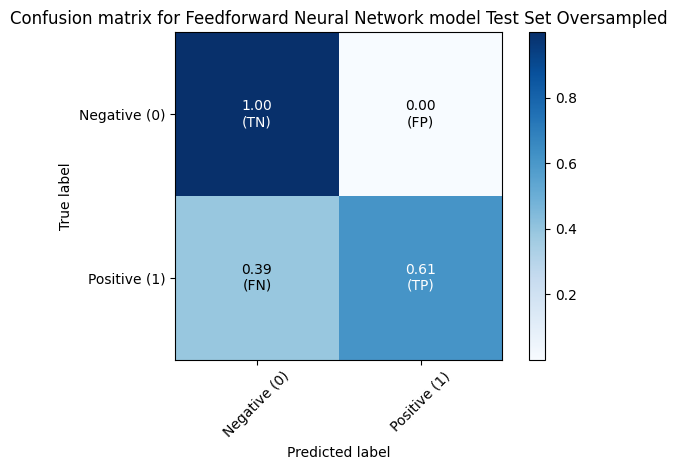

In [233]:
# make predictions for test set
y_pred_feed_resampled = model.predict(X_test)
y_test_feed_resampled = pd.DataFrame(y_test)

# Calculate the confusion matrix and plot it for test set
cnf_matrix = confusion_matrix(y_test_feed_resampled, y_pred_feed_resampled.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Feedforward Neural Network model Test Set Oversampled')


In [201]:
# calculate metrics for test set resampled
accuracy = accuracy_score(y_test_feed_resampled, y_pred_feed_resampled.round())
precision = precision_score(y_test_feed_resampled, y_pred_feed_resampled.round())
recall = recall_score(y_test_feed_resampled, y_pred_feed_resampled.round())
f1 = f1_score(y_test_feed_resampled, y_pred_feed_resampled.round())

# print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.9993
Precision: 0.9333
Recall: 0.6667
F1 Score: 0.7778


8901/8901 [==============================] - 3s 353us/step
Confusion Matrix 
[[284298     17]
 [   164    328]]
Normalized confusion matrix
[[9.99940207e-01 5.97928354e-05]
 [3.33333333e-01 6.66666667e-01]]


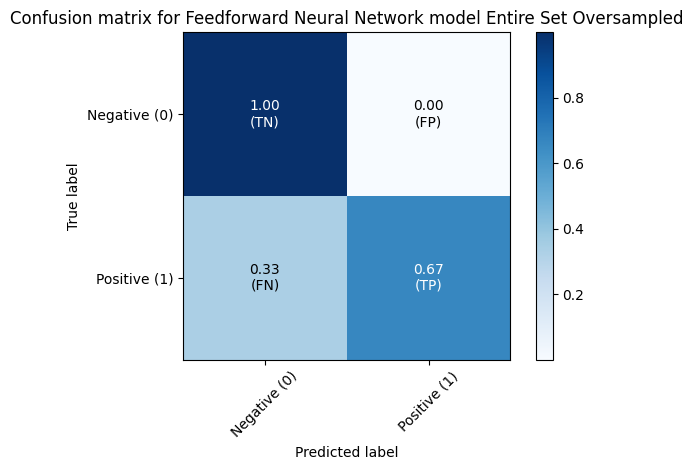

In [234]:
# make predictions for entire set resampled
y_pred_feed_resampled_all = model.predict(X)
y_test_feed_resampled_all = pd.DataFrame(y)

# Calculate the confusion matrix and plot it for entire set
cnf_matrix = confusion_matrix(y_test_feed_resampled_all, y_pred_feed_resampled_all.round())
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Feedforward Neural Network model Entire Set Oversampled')



In [203]:
# calculate metrics for entire set resampled
accuracy = accuracy_score(y_test_feed_resampled_all, y_pred_feed_resampled_all.round())
precision = precision_score(y_test_feed_resampled_all, y_pred_feed_resampled_all.round())
recall = recall_score(y_test_feed_resampled_all, y_pred_feed_resampled_all.round())
f1 = f1_score(y_test_feed_resampled_all, y_pred_feed_resampled_all.round())

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.9994
Precision: 0.9512
Recall: 0.7134
F1 Score: 0.8153


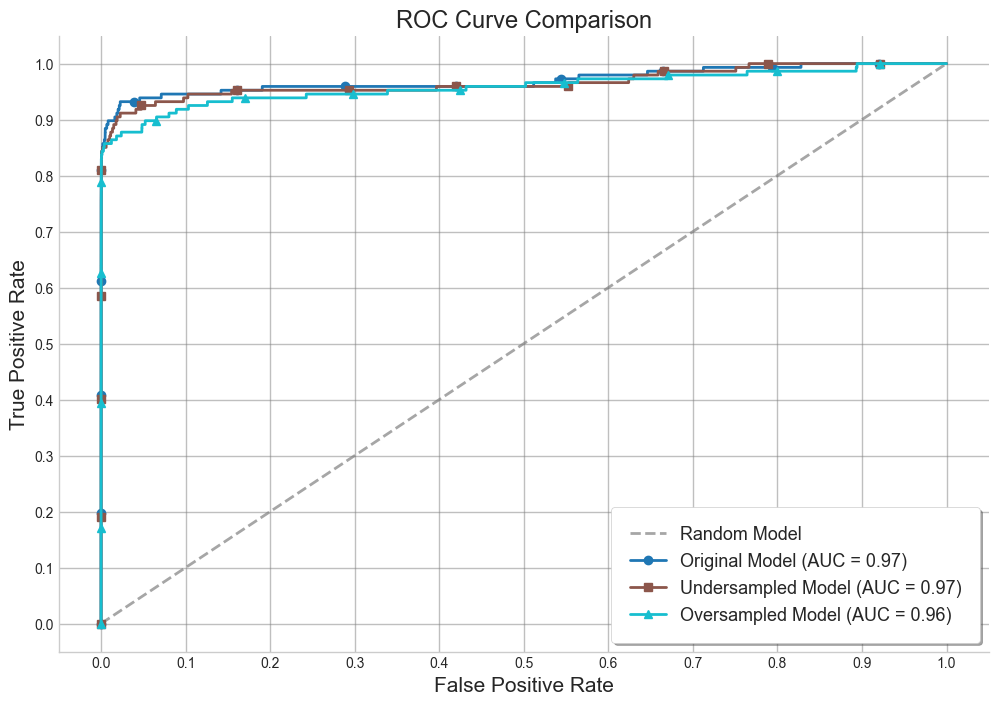

In [254]:
# Preparing data for plotting
y_tests = [y_test, y_test_feed_undersampled, y_test_feed_resampled]
y_scores = [y_pred_feed.flatten(), y_pred_feed_undersampled.flatten(), y_pred_feed_resampled.flatten()]
labels = ['Original Model', 'Undersampled Model', 'Oversampled Model']

# Plot ROC curves
plot_roc_curve(y_tests, y_scores, labels)

## **6. Autoencoder Model for Anomaly Detection**

In [267]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(199364, 29)
(85443, 29)
(199364,)
(85443,)


In [256]:
y_train = y_train.squeeze() 
y_test = y_test.squeeze()  

BAYESIAN OPTMIZATION FOR HYPERPARAMETER 

In [268]:
# Define the function to optimize
def autoencoder_cv(n_neurons):
    input_dim = X_train.shape[1]  # Number of features
    n_neurons = int(n_neurons)
    
    # Encoder
    encoder = models.Sequential([
        layers.Dense(n_neurons, activation="tanh", input_shape=(input_dim,)),
        layers.Dense(int(n_neurons / 2), activation="relu")
    ])
    
    # Decoder
    decoder = models.Sequential([
        layers.Dense(n_neurons, activation="tanh"),
        layers.Dense(input_dim, activation="relu")
    ])
    
    # Autoencoder
    autoencoder = models.Sequential([encoder, decoder])
    
    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    
    # Train the autoencoder
    autoencoder.fit(X_train, X_train,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=0, 
                    callbacks=[early_stopping])
    
    # Evaluate the model on the test set
    val_loss = autoencoder.evaluate(X_test, X_test, verbose=0)
    
    return -val_loss

# Bounded region of parameter space
pbounds = {'n_neurons': (16, 128)}  

optimizer = BayesianOptimization(
    f=autoencoder_cv,
    pbounds=pbounds,
    random_state=1,
)

# Optimization
optimizer.maximize(init_points=2, n_iter=3)

# Best parameters found
best_params = optimizer.max['params']
n_neurons_best = int(best_params['n_neurons'])
print(f"Best parameters: {best_params}")

|   iter    |  target   | n_neurons |
-------------------------------------
| 1         | -0.5892   | 62.71     |
| 2         | -0.5915   | 96.68     |
| 3         | -0.5894   | 64.02     |
| 4         | -0.6049   | 47.86     |
| 5         | -0.5901   | 81.79     |
Best parameters: {'n_neurons': 62.706464526688286}


Autoencoder

In [269]:
# Reconstruct and retrain the model with the optimized parameters
input_dim = X_train.shape[1]

# Encoder
encoder_opt = models.Sequential([
    layers.Dense(n_neurons_best, activation="tanh", input_shape=(input_dim,)),
    layers.Dense(int(n_neurons_best / 2), activation="relu")
])

# Decoder
decoder_opt = models.Sequential([
    layers.Dense(n_neurons_best, activation="tanh"),
    layers.Dense(input_dim, activation="relu")
])

In [270]:
# Autoencoder
autoencoder_opt = models.Sequential([encoder_opt, decoder_opt])

# Compile the model
autoencoder_opt.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the autoencoder
autoencoder_opt.fit(X_train, X_train,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,  # You can turn off the verbose for less output
                    callbacks=[early_stopping])

Epoch 1/100
779/779 [==============================] - 2s 1ms/step - loss: 0.7148 - val_loss: 0.6341
Epoch 2/100
779/779 [==============================] - 1s 1ms/step - loss: 0.6222 - val_loss: 0.6153
Epoch 3/100
779/779 [==============================] - 1s 1ms/step - loss: 0.6106 - val_loss: 0.6092
Epoch 4/100
779/779 [==============================] - 1s 1ms/step - loss: 0.6063 - val_loss: 0.6059
Epoch 5/100
779/779 [==============================] - 1s 2ms/step - loss: 0.6022 - val_loss: 0.6002
Epoch 6/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5991 - val_loss: 0.5981
Epoch 7/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5980 - val_loss: 0.5975
Epoch 8/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5973 - val_loss: 0.5972
Epoch 9/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5971 - val_loss: 0.5970
Epoch 10/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5966 - val_lo

2671/2671 [==============================] - 1s 383us/step
Confusion Matrix 
[[81149  4147]
 [   21   126]]
Normalized confusion matrix
[[0.95138107 0.04861893]
 [0.14285714 0.85714286]]


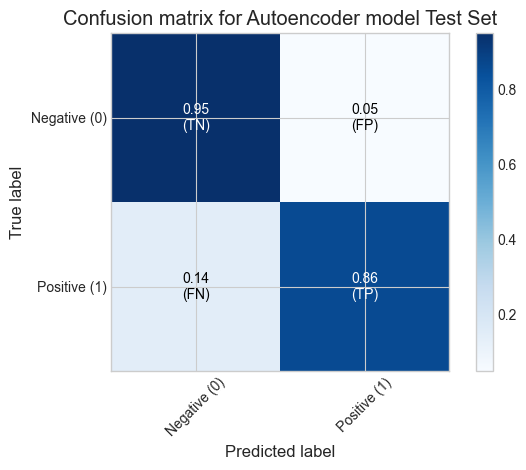

In [303]:
# Predict on the test set
reconstructed = autoencoder_opt.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)
mse = np.array(mse)  
mse = mse.reshape(-1, 1)

# Use a threshold to classify transactions as normal or anomaly
threshold = np.quantile(mse, 0.95)  # Adjust based on your requirement
y_pred_autoencoder = [1 if e > threshold else 0 for e in mse.flatten()]

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_autoencoder)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Autoencoder model Test Set')
plt.show()

In [272]:
# calculate metrics for test set autoencoder
accuracy = accuracy_score(y_test, y_pred_autoencoder)
precision = precision_score(y_test, y_pred_autoencoder)
recall = recall_score(y_test, y_pred_autoencoder)
f1 = f1_score(y_test, y_pred_autoencoder)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9512
Precision: 0.0295
Recall: 0.8571
F1 Score: 0.0570


In [213]:
print(y_test.shape)

(85443,)


8901/8901 [==============================] - 5s 520us/step
Confusion Matrix 
[[270491  13824]
 [    75    417]]
Normalized confusion matrix
[[0.95137787 0.04862213]
 [0.15243902 0.84756098]]


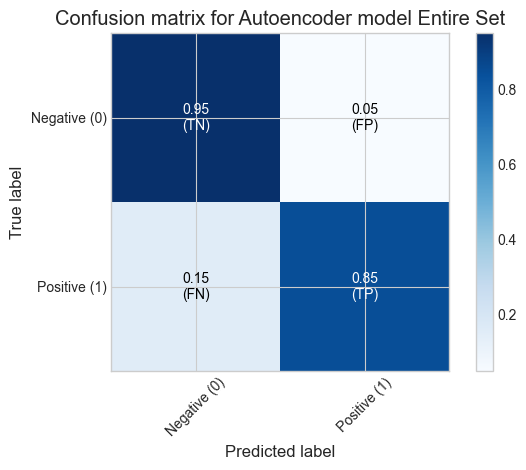

In [273]:
# Predict on the test set
reconstructed_all = autoencoder_opt.predict(X)

# Compute reconstruction error
mse = np.mean(np.power(X - reconstructed_all, 2), axis=1)
mse = np.array(mse)  
mse = mse.reshape(-1, 1)

# Use a threshold to classify transactions as normal or anomaly
threshold = np.quantile(mse, 0.95)  # Adjust based on your requirement
y_pred_autoencoder_all = [1 if e > threshold else 0 for e in mse.flatten()]

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y,y_pred_autoencoder_all)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Autoencoder model Entire Set')

In [274]:
# calculate metrics for entire set autoencoder
accuracy = accuracy_score(y, y_pred_autoencoder_all)
precision = precision_score(y, y_pred_autoencoder_all)
recall = recall_score(y, y_pred_autoencoder_all)
f1 = f1_score(y, y_pred_autoencoder_all)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9512
Precision: 0.0293
Recall: 0.8476
F1 Score: 0.0566


UNDERSAMPLE

In [275]:
# Define the function to optimize
def autoencoder_cv_undersampled(n_neurons):
    input_dim = X_train_undersample.shape[1]  # Number of features
    n_neurons = int(n_neurons)
    
    # Encoder
    encoder_undersample = models.Sequential([
        layers.Dense(n_neurons, activation="tanh", input_shape=(input_dim,)),
        layers.Dense(int(n_neurons / 2), activation="relu")
    ])
    
    # Decoder
    decoder_undersample = models.Sequential([
        layers.Dense(n_neurons, activation="tanh"),
        layers.Dense(input_dim, activation="relu")
    ])
    
    # Autoencoder
    autoencoder_undersampled = models.Sequential([encoder_undersample, decoder_undersample])
    
    # Compile the model
    autoencoder_undersampled.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    
    # Train the autoencoder
    autoencoder_undersampled.fit(X_train_undersample, X_train_undersample,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=0, 
                    callbacks=[early_stopping])
    
    # Evaluate the model on the test set
    val_loss = autoencoder_undersampled.evaluate(X_test, X_test, verbose=0)
    
    return -val_loss

# Bounded region of parameter space
pbounds = {'n_neurons': (16, 128)}  

optimizer = BayesianOptimization(
    f=autoencoder_cv_undersampled,
    pbounds=pbounds,
    random_state=1,
)

# Optimization
optimizer.maximize(init_points=2, n_iter=3)

# Best parameters found
best_params_undersampled = optimizer.max['params']
n_neurons_best_undersampled = int(best_params_undersampled['n_neurons'])
print(f"Best parameters: {best_params_undersampled}")

|   iter    |  target   | n_neurons |
-------------------------------------
| 1         | -0.5892   | 62.71     |
| 2         | -0.5903   | 96.68     |
| 3         | -0.5892   | 64.02     |
| 4         | -0.7008   | 16.01     |
| 5         | -0.5889   | 128.0     |
Best parameters: {'n_neurons': 128.0}


In [276]:
# Reconstruct and retrain the model with the optimized parameters
input_dim = X_train.shape[1]

# Encoder
encoder_opt_undersample = models.Sequential([
    layers.Dense(n_neurons_best_undersampled, activation="tanh", input_shape=(input_dim,)),
    layers.Dense(int(n_neurons_best_undersampled / 2), activation="relu")
])

# Decoder
decoder_opt_undersample = models.Sequential([
    layers.Dense(n_neurons_best_undersampled, activation="tanh"),
    layers.Dense(input_dim, activation="relu")
])

# Autoencoder
autoencoder_opt_undersampled = models.Sequential([encoder_opt_undersample, decoder_opt_undersample])

# Compile the model
autoencoder_opt_undersampled.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the autoencoder
autoencoder_opt_undersampled.fit(X_train_undersample, X_train_undersample,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,  # You can turn off the verbose for less output
                    callbacks=[early_stopping])

Epoch 1/100
1558/1558 [==============================] - 5s 3ms/step - loss: 0.6319 - val_loss: 0.5993
Epoch 2/100
1558/1558 [==============================] - 3s 2ms/step - loss: 0.5961 - val_loss: 0.5940
Epoch 3/100
1558/1558 [==============================] - 2s 2ms/step - loss: 0.5941 - val_loss: 0.5940
Epoch 4/100
1558/1558 [==============================] - 2s 1ms/step - loss: 0.5929 - val_loss: 0.5916
Epoch 5/100
1558/1558 [==============================] - 2s 1ms/step - loss: 0.5930 - val_loss: 0.5924
Epoch 6/100
1558/1558 [==============================] - 3s 2ms/step - loss: 0.5926 - val_loss: 0.5917
Epoch 7/100
1558/1558 [==============================] - 3s 2ms/step - loss: 0.5923 - val_loss: 0.5903
Epoch 8/100
1558/1558 [==============================] - 2s 2ms/step - loss: 0.5917 - val_loss: 0.5977
Epoch 9/100
1558/1558 [==============================] - 2s 2ms/step - loss: 0.5922 - val_loss: 0.5936
Epoch 10/100
1558/1558 [==============================] - 3s 2ms/step - l

2671/2671 [==============================] - 1s 402us/step
Confusion Matrix 
[[81150  4146]
 [   20   127]]
Normalized confusion matrix
[[0.9513928  0.0486072 ]
 [0.13605442 0.86394558]]


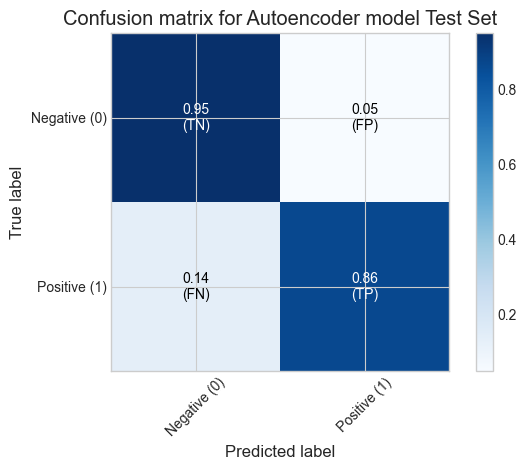

In [277]:
# Predict on the test set
reconstructed_undersampled = autoencoder_opt_undersampled.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - reconstructed_undersampled, 2), axis=1)
mse = np.array(mse)  
mse = mse.reshape(-1, 1)

# Use a threshold to classify transactions as normal or anomaly
threshold = np.quantile(mse, 0.95)  # Adjust based on your requirement
y_pred_autoencoder_undersample = [1 if e > threshold else 0 for e in mse.flatten()]

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_autoencoder_undersample)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Autoencoder model Test Set')
plt.show()

In [278]:
# calculate metrics for test set autoencoder
accuracy = accuracy_score(y_test, y_pred_autoencoder_undersample)
precision = precision_score(y_test, y_pred_autoencoder_undersample)
recall = recall_score(y_test, y_pred_autoencoder_undersample)
f1 = f1_score(y_test, y_pred_autoencoder_undersample)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9512
Precision: 0.0297
Recall: 0.8639
F1 Score: 0.0575


8901/8901 [==============================] - 4s 404us/step
Confusion Matrix 
[[270492  13823]
 [    74    418]]
Normalized confusion matrix
[[0.95138139 0.04861861]
 [0.1504065  0.8495935 ]]


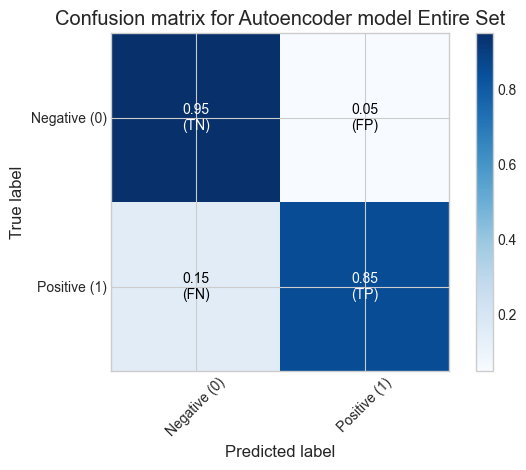

In [279]:
# Predict on the entire set
reconstructed_undersampled_all = autoencoder_opt_undersampled.predict(X)

# Compute reconstruction error
mse = np.mean(np.power(X - reconstructed_undersampled_all, 2), axis=1)
mse = np.array(mse)  
mse = mse.reshape(-1, 1)

# Use a threshold to classify transactions as normal or anomaly
threshold = np.quantile(mse, 0.95)  # Adjust based on your requirement
y_pred_autoencoder_undersampled_all = [1 if e > threshold else 0 for e in mse.flatten()]

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y,y_pred_autoencoder_undersampled_all)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Autoencoder model Entire Set')

In [280]:
# calculate metrics for entire set autoencoder
accuracy = accuracy_score(y, y_pred_autoencoder_undersampled_all)
precision = precision_score(y, y_pred_autoencoder_undersampled_all)
recall = recall_score(y, y_pred_autoencoder_undersampled_all)
f1 = f1_score(y, y_pred_autoencoder_undersampled_all)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9512
Precision: 0.0294
Recall: 0.8496
F1 Score: 0.0567


OVERSAMPLED

In [283]:
# Define the function to optimize
def autoencoder_cv_oversampled(n_neurons):
    input_dim = X_train_resampled.shape[1]  # Number of features
    n_neurons = int(n_neurons)
    
    # Encoder
    encoder_oversampled = models.Sequential([
        layers.Dense(n_neurons, activation="tanh", input_shape=(input_dim,)),
        layers.Dense(int(n_neurons / 2), activation="relu")
    ])
    
    # Decoder
    decoder_oversampled = models.Sequential([
        layers.Dense(n_neurons, activation="tanh"),
        layers.Dense(input_dim, activation="relu")
    ])
    
    # Autoencoder
    autoencoder_oversampled = models.Sequential([encoder_oversampled, decoder_oversampled])
    
    # Compile the model
    autoencoder_oversampled.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    
    # Train the autoencoder
    autoencoder_oversampled.fit(X_train_resampled, X_train_resampled,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=0, 
                    callbacks=[early_stopping])
    
    # Evaluate the model on the test set
    val_loss = autoencoder_oversampled.evaluate(X_test, X_test, verbose=0)
    
    return -val_loss

# Bounded region of parameter space
pbounds = {'n_neurons': (16, 128)}  

optimizer = BayesianOptimization(
    f=autoencoder_cv_oversampled,
    pbounds=pbounds,
    random_state=1,
)

# Optimization
optimizer.maximize(init_points=2, n_iter=3)

# Best parameters found
best_params_oversampled = optimizer.max['params']
n_neurons_best_oversampled = int(best_params_oversampled['n_neurons'])
print(f"Best parameters: {best_params_oversampled}")

|   iter    |  target   | n_neurons |
-------------------------------------
| 1         | -0.5904   | 62.71     |
| 2         | -0.5892   | 96.68     |
| 3         | -0.5892   | 97.98     |
| 4         | -0.5897   | 128.0     |
| 5         | -0.6988   | 16.02     |
Best parameters: {'n_neurons': 97.98159436455038}


In [284]:
# Reconstruct and retrain the model with the optimized parameters
input_dim = X_train.shape[1]

# Encoder
encoder_opt_oversampled = models.Sequential([
    layers.Dense(n_neurons_best_oversampled, activation="tanh", input_shape=(input_dim,)),
    layers.Dense(int(n_neurons_best_oversampled / 2), activation="relu")
])

# Decoder
decoder_opt_oversampled = models.Sequential([
    layers.Dense(n_neurons_best_oversampled, activation="tanh"),
    layers.Dense(input_dim, activation="relu")
])

# Autoencoder
autoencoder_opt_oversampled = models.Sequential([encoder_opt_oversampled, decoder_opt_oversampled])

# Compile the model
autoencoder_opt_oversampled.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the autoencoder
autoencoder_opt_oversampled.fit(X_train_resampled, X_train_resampled,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,  # You can turn off the verbose for less output
                    callbacks=[early_stopping])



Epoch 1/100
779/779 [==============================] - 2s 2ms/step - loss: 0.6621 - val_loss: 0.6146
Epoch 2/100
779/779 [==============================] - 2s 3ms/step - loss: 0.6058 - val_loss: 0.6017
Epoch 3/100
779/779 [==============================] - 1s 2ms/step - loss: 0.5985 - val_loss: 0.5976
Epoch 4/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5960 - val_loss: 0.5952
Epoch 5/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5953 - val_loss: 0.5951
Epoch 6/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5940 - val_loss: 0.5949
Epoch 7/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5937 - val_loss: 0.5929
Epoch 8/100
779/779 [==============================] - 1s 1ms/step - loss: 0.5931 - val_loss: 0.5922
Epoch 9/100
779/779 [==============================] - 1s 2ms/step - loss: 0.5929 - val_loss: 0.5915
Epoch 10/100
779/779 [==============================] - 1s 2ms/step - loss: 0.5926 - val_lo

2671/2671 [==============================] - 1s 385us/step
Confusion Matrix 
[[81150  4146]
 [   20   127]]
Normalized confusion matrix
[[0.9513928  0.0486072 ]
 [0.13605442 0.86394558]]


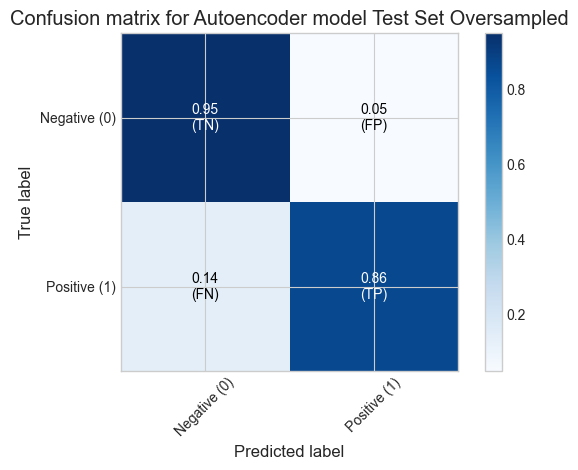

In [292]:
# Predict on the test set
reconstructed_oversampled = autoencoder_opt_oversampled.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - reconstructed_oversampled, 2), axis=1)
mse = np.array(mse)  
mse = mse.reshape(-1, 1)

# Use a threshold to classify transactions as normal or anomaly
threshold = np.quantile(mse, 0.95)  # Adjust based on your requirement
y_pred_autoencoder_oversample = [1 if e > threshold else 0 for e in mse.flatten()]

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_autoencoder_oversample)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Autoencoder model Test Set Oversampled')
plt.show()

In [286]:
# calculate metrics for test set autoencoder
accuracy = accuracy_score(y_test, y_pred_autoencoder_oversample)    
precision = precision_score(y_test, y_pred_autoencoder_oversample)
recall = recall_score(y_test, y_pred_autoencoder_oversample)
f1 = f1_score(y_test, y_pred_autoencoder_oversample)

# print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9512
Precision: 0.0297
Recall: 0.8639
F1 Score: 0.0575


8901/8901 [==============================] - 3s 383us/step
Confusion Matrix 
[[270492  13823]
 [    74    418]]
Normalized confusion matrix
[[0.95138139 0.04861861]
 [0.1504065  0.8495935 ]]


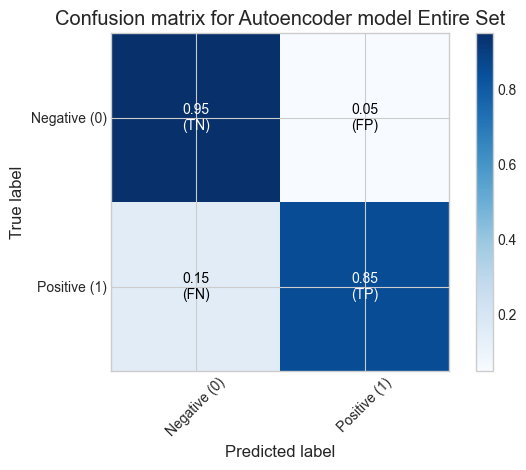

In [289]:
# Predict on the entire set
reconstructed_all_oversampled = autoencoder_opt_oversampled.predict(X)

# Compute reconstruction error
mse = np.mean(np.power(X - reconstructed_all_oversampled, 2), axis=1)
mse = np.array(mse)  
mse = mse.reshape(-1, 1)

# Use a threshold to classify transactions as normal or anomaly
threshold = np.quantile(mse, 0.95)  # Adjust based on your requirement
y_pred_autoencoder_all_oversampled = [1 if e > threshold else 0 for e in mse.flatten()]

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y,y_pred_autoencoder_all_oversampled)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'], title='Confusion matrix for Autoencoder model Entire Set')

In [288]:
# calculate metrics for entire set autoencoder
accuracy = accuracy_score(y, y_pred_autoencoder_all_oversampled)
precision = precision_score(y, y_pred_autoencoder_all_oversampled)
recall = recall_score(y, y_pred_autoencoder_all_oversampled)
f1 = f1_score(y, y_pred_autoencoder_all_oversampled)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9512
Precision: 0.0294
Recall: 0.8496
F1 Score: 0.0567


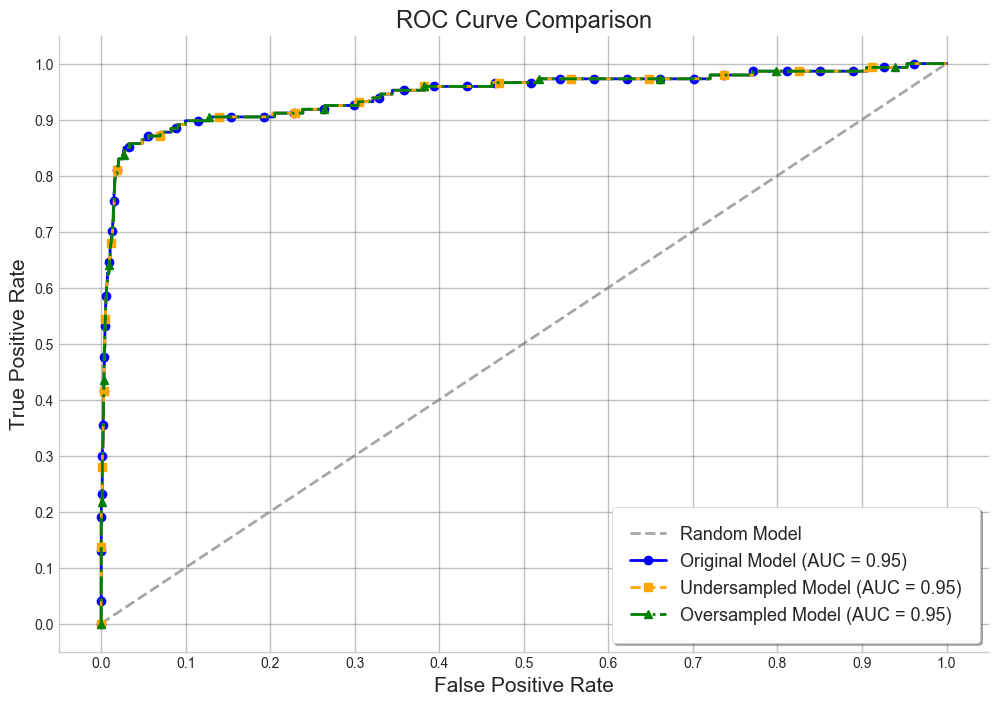

In [368]:
# 'mse' for original model
mse_original = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# 'mse' for undersampled model
mse_undersampled = np.mean(np.power(X_test - reconstructed_undersampled, 2), axis=1)

# 'mse' for oversampled model
mse_oversampled = np.mean(np.power(X_test - reconstructed_oversampled, 2), axis=1)

# Convert MSEs to a format suitable for ROC curves

y_scores = [mse_original, mse_undersampled, mse_oversampled]

# Your true labels remain the same across all models
y_tests = [y_test, y_test, y_test]

# Labels for your models to be used in the legend of the ROC plot
labels = ['Original Model', 'Undersampled Model', 'Oversampled Model']



# Plot ROC curves
plot_roc_curve(y_tests, y_scores, labels)

## MODELS' PERFORMANCE COMPARISON

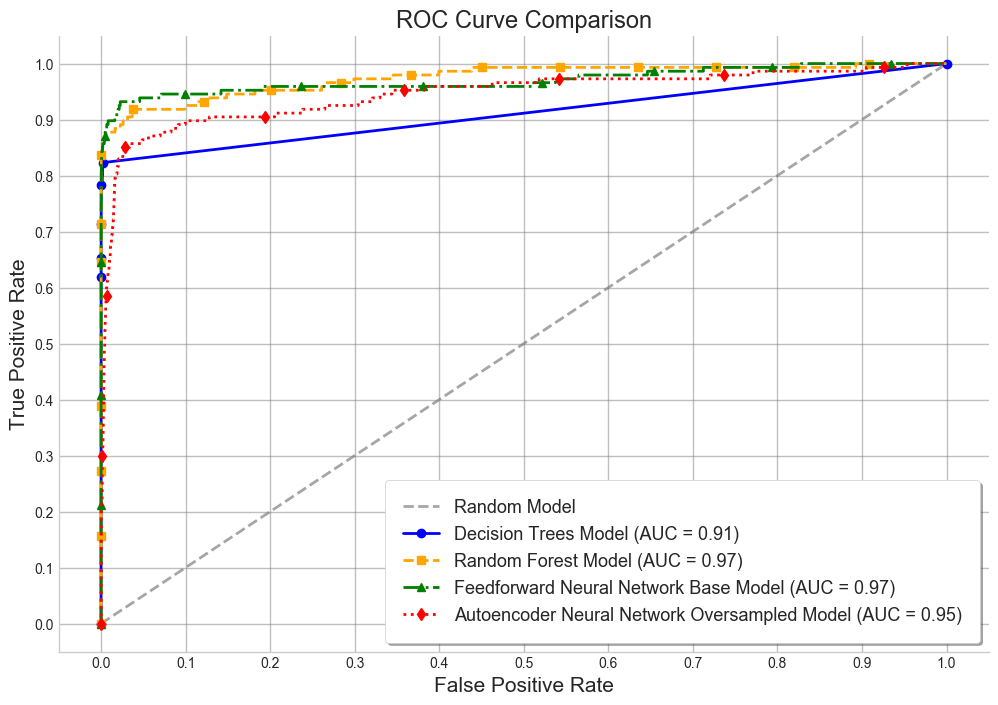

In [370]:
# Preparing data for plotting
y_tests = [y_test, y_expected_random_forest, y_test, y_test]  # Adjust based on your actual labels
y_pred_random_forest = pd.DataFrame(y_pred_random_forest)
y_scores = [
    best_model.predict_proba(X_test)[:, 1],  # Trees Model 
    bayes_search.predict_proba(X_test)[:, 1],  # Random Forest Model
    y_pred_feed.flatten(),  # Feedforward Model Base Model
    mse_oversampled # Autoencoder Model Oversampled
]
labels = ['Decision Trees Model', 'Random Forest Model', 'Feedforward Neural Network Base Model', 'Autoencoder Neural Network Oversampled Model']

# Plot ROC curves
plot_roc_curve(y_tests, y_scores, labels)

In [363]:
#print the type of y_pred_decision_tress
print(type(y_pred_decision_tress))


<class 'numpy.ndarray'>
